In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from matplotlib import pyplot as plt

In [24]:
train_data = datasets.MNIST(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [25]:
next(iter(train_data))

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [30]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=4)

In [31]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [32]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [33]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([7], device='cuda:0')


In [34]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred.to('cpu'), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device)).to('cpu')
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [36]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298329  [    0/60000]
loss: 2.298831  [ 6400/60000]
loss: 2.287730  [12800/60000]
loss: 2.282374  [19200/60000]
loss: 2.282781  [25600/60000]
loss: 2.272223  [32000/60000]
loss: 2.277282  [38400/60000]
loss: 2.279408  [44800/60000]
loss: 2.272732  [51200/60000]
loss: 2.265556  [57600/60000]
Test Error: 
 Accuracy: 51.2%, Avg loss: 2.256414 

Epoch 2
-------------------------------
loss: 2.255497  [    0/60000]
loss: 2.244694  [ 6400/60000]
loss: 2.251168  [12800/60000]
loss: 2.247968  [19200/60000]
loss: 2.231690  [25600/60000]
loss: 2.221483  [32000/60000]
loss: 2.230842  [38400/60000]
loss: 2.215922  [44800/60000]
loss: 2.212620  [51200/60000]
loss: 2.209049  [57600/60000]
Test Error: 
 Accuracy: 63.2%, Avg loss: 2.192216 

Epoch 3
-------------------------------
loss: 2.205112  [    0/60000]
loss: 2.183983  [ 6400/60000]
loss: 2.186877  [12800/60000]
loss: 2.197786  [19200/60000]
loss: 2.153151  [25600/60000]
loss: 2.153176  [32000/600

---
## Active Learning

In [1]:
import sys

import sklearn.datasets
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

c:\Users\mai\anaconda3\envs\bmc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")
# import pickle
# with open('data.p', 'wb') as f:
#     pickle.dump(mnist, f)

In [3]:
import pickle
with open("data.p", 'rb') as f:
    mnist = pickle.load(f)

In [7]:
Data = mnist["data"]
Data["target"] = mnist["target"]

Data = Data.sample(frac=1, random_state=1998, ignore_index=True)

In [ ]:
# train
loop = 8
sample = 5000

# valid / test
valid_size = 5000
test_size = 20000 

In [ ]:
train_image_set = Data.iloc[:-1 * test_size,:-1]
train_label_set = Data.iloc[:-1 * test_size,-1:]

vaild_image_set = train_image_set.iloc[-1 * valid_size:,:-1].to_numpy().reshape(-1,28,28)
vaild_label_set = train_label_set.iloc[-1 * valid_size:,-1:].astype(int).to_numpy()
train_image_set = train_image_set.iloc[:-1 * valid_size,:-1].to_numpy().reshape(-1,28,28)
train_label_set = train_label_set.iloc[:-1 * valid_size,-1:].astype(int).to_numpy()
test_image_set = Data.iloc[-1 * test_size:,:-1].to_numpy().reshape(-1,28,28)
test_label_set = Data.iloc[-1 * test_size:,-1:].astype(int).to_numpy()

In [7]:
train_image_set = torch.from_numpy(train_image_set).to(torch.float32)
train_label_set = torch.from_numpy(train_label_set).to(torch.long).squeeze(dim=1)
vaild_image_set = torch.from_numpy(vaild_image_set).to(torch.float32)
vaild_label_set = torch.from_numpy(vaild_label_set).to(torch.long).squeeze(dim=1)
test_image_set = torch.from_numpy(test_image_set).to(torch.float32)
test_label_set = torch.from_numpy(test_label_set).to(torch.long).squeeze(dim=1)

---

In [ ]:
vaild_label_set = DataLoader(TensorDataset(vaild_image_set, vaild_label_set), batch_size=64,num_workers=0)
test_dataloader = DataLoader(TensorDataset(test_image_set, test_label_set), batch_size=64,num_workers=0)

In [26]:
train_dataloader = DataLoader(TensorDataset(t_Image, t_Label), batch_size=64)
test_dataloader = DataLoader(TensorDataset(v_Image, v_Label), batch_size=64,num_workers=0)

In [27]:
# train_dataloader = DataLoader(TensorDataset(Image[:-10000], Label[:-10000]), batch_size=64,num_workers=4)
# test_dataloader = DataLoader(TensorDataset(Image[-10000:], Label[-10000:]), batch_size=64,num_workers=4)

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [29]:
learning_rate = 1e-5
batch_size = 64
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [30]:
graph_trn_loss = []
graph_tst_loss = []
graph_tst_acc = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred.to('cpu'), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            graph_trn_loss.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device)).to('cpu')
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    graph_tst_loss.append(test_loss)
    graph_tst_acc.append(100*correct)
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
graph_trn_loss = []
graph_tst_loss = []
graph_tst_acc = []

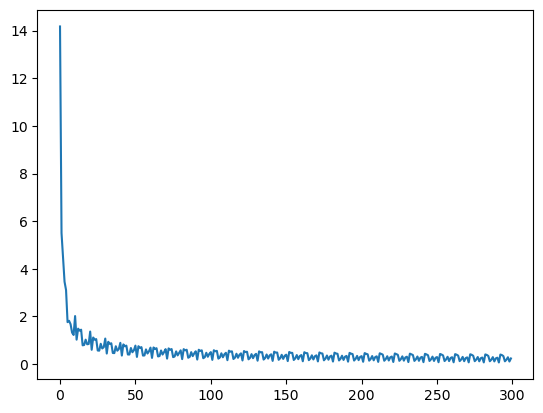

In [26]:
plt.plot(graph_trn_loss)
plt.show()

In [6]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array(['5'], dtype=object)

In [211]:
indices = torch.randperm(X.size(0))

TypeError: 'numpy.int32' object is not callable

In [215]:
X, y = mnist["data"], mnist["target"]

In [81]:
X, y = mnist["data"], mnist["target"]

In [216]:
X.shape

(70000, 784)

In [82]:
train_set = 
test_set = X[10000:]

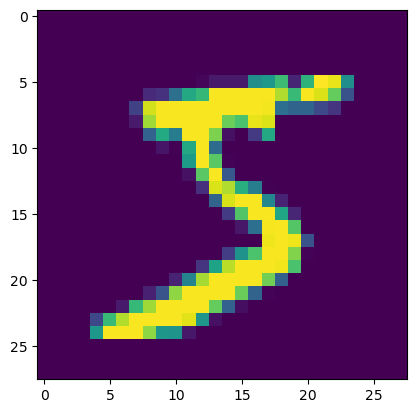

In [83]:
plt.imshow(tmp)

70000

데이터 구성